----
Code for segmenting roads from satellite images using the pre-trained Unet.
----

In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models

In [ ]:
import skimage

import tensorflow as tf
from tensorflow import keras

import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator

import skimage.io as io
import skimage.transform as trans
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import datasets, layers, models
from keras.utils import plot_model

from segmentation_models import Unet
from keras.optimizers import Adam
from segmentation_models.losses import bce_jaccard_loss, bce_dice_loss
from segmentation_models.metrics import iou_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Global variables

In [ ]:
img_size = 400
batch_size = 1
seed = 42
n_train_images = 100
img_resized_size = 32 * 8
encoder_freeze = False

transfer_model = "efficientnetb0"
custom_name = "" # string you should personalize if you want to save your model's weights (and don't want others to override them)
model_name = 'model_freeze=' + str(encoder_freeze) + '_' + transfer_model + '.h5'

# Loading the data

In [ ]:
def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

In [ ]:
#Load the images and there ground truth 
root_dir = "/content/drive/My Drive/project 2/Stalletite_images_segmentation/Datasets/training/"

image_dir = root_dir + "images/" #data path
gt_dir = root_dir + "groundtruth/" #label path

#files to load
files = os.listdir(image_dir)
n = min(1000, len(files)) # Load maximum 20 images

print("Loading " + str(n) + " images")
imgs = np.array([load_image(image_dir + files[i]) for i in range(n)])

print("Loading " + str(n) + " labels")
gt_imgs = np.array([load_image(gt_dir + files[i]) for i in range(n)])

Loading 100 images
Loading 100 labels


In [ ]:
imgs_ext = imgs
gts_ext = gt_imgs
if img_size == 400: # just reshape
    gts_ext = gts_ext.reshape((n_train_images, img_size, img_size, 1))
#else: # == 608, resize train images/masks from 400 to 608
imgs_ext = np.array([skimage.transform.resize(image, (img_resized_size, img_resized_size, 3)) for image in imgs_ext])
gts_ext = np.array([skimage.transform.resize(image, (img_resized_size, img_resized_size, 1)) for image in gts_ext])

(100, 256, 256, 3)


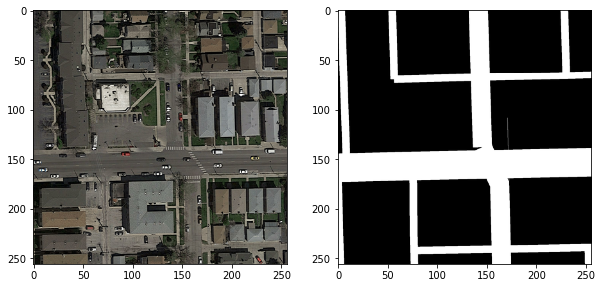

In [ ]:
n=11

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(imgs_ext[n])
plt.subplot(122)
plt.imshow(gts_ext[n].reshape((img_resized_size,img_resized_size)), cmap='Greys_r')
print(imgs_ext.shape)

# More data!

#### Data augmentation with keras functions(Don't run it for now!!!)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   vertical_flip=True,
                                   rotation_range=360,
                                   fill_mode="reflect",
                                   shear_range=0.2,
                                   zoom_range=0.2)

val_datagen = ImageDataGenerator(horizontal_flip=True,
                                 vertical_flip=True,
                                 rotation_range=360,
                                 fill_mode="reflect",
                                 shear_range=0.2,
                                 zoom_range=0.2)
# flow from memory
train_image_generator = train_datagen.flow(imgs_ext, seed=seed)
train_mask_generator = train_datagen.flow(gts_ext, seed=seed)

# flow from directory
#train_image_generator = train_datagen.flow_from_directory(imgs_ext, seed=seed)
#train_mask_generator = train_datagen.flow_from_directory(gts_ext, seed=seed)

train_generator = (pair for pair in zip(train_image_generator, train_mask_generator))

(100, 256, 256, 3)


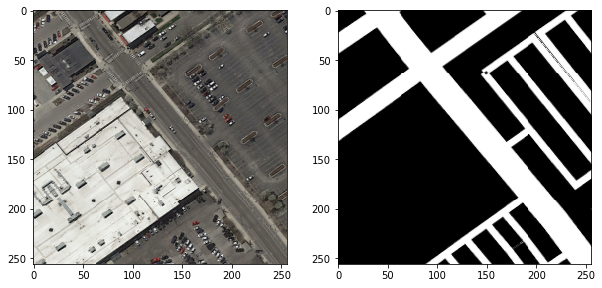

In [ ]:
n=0

x_batch, y_batch = next(train_generator)

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(x_batch[n])
plt.subplot(122)
plt.imshow(y_batch[n].reshape((img_resized_size, img_resized_size)), cmap='Greys_r')
print(imgs_ext.shape)

# Model building

In [ ]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Training

### Training callbacks

In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# reduces learning rate on plateau
lr_reducer = ReduceLROnPlateau(factor=0.1,
                               cooldown= 10,
                               patience=10,verbose =1,
                               min_lr=0.1e-5)
# model autosave callbacks
mode_autosave = ModelCheckpoint("/content/drive/My Drive/project 2/Stalletite_images_segmentation/model_checkpoint.h5", 
                                monitor='val_iou_score', 
                                mode='max', save_best_only=True, verbose=1, period=10)

# stop learining as metric on validatopn stop increasing
early_stopping = EarlyStopping(patience=10, verbose=1, mode = 'auto') 

callbacks = [mode_autosave, lr_reducer, early_stopping]

In [ ]:
model = Unet(backbone_name = transfer_model, encoder_weights='imagenet', encoder_freeze = encoder_freeze)
model.compile(optimizer = Adam(),
                    loss=bce_jaccard_loss, metrics=[iou_score, f1_m, precision_m, recall_m])
model.summary()

In [ ]:
model.load_weights('/content/drive/My Drive/project 2/Stalletite_images_segmentation/' + model_name)

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch = 128, epochs=20)

In [ ]:
model.save_weights('/content/drive/My Drive/project 2/Stalletite_images_segmentation/' + model_name)

In [ ]:
# The returned "history" object holds a record
# of the loss values and metric values during training
print(history.history.keys())
bce = history.history['loss']
#val_loss = history.history['val_loss']
p=np.array(history.history['precision_m'])
r=np.array(history.history['recall_m'])
F1 = np.array(history.history['f1_m'])
#F1 = 2* (p*r)/(p+r)


plt.figure(figsize=(17,7))
plt.subplot(141)
plt.title('Binary Cross Entropy')
plt.plot(bce)
#plt.plot(val_loss)


plt.subplot(142)
plt.title('Precision')
plt.plot(p)

plt.subplot(143)
plt.title('Recall')
plt.plot(r)

plt.subplot(144)
plt.title('F1 score')
plt.plot(F1)


# Check results

In [ ]:
train_seg = model.predict(np.array(imgs_ext))

train_seg=np.array(train_seg)

In [ ]:
train_seg.shape

(100, 256, 256, 1)

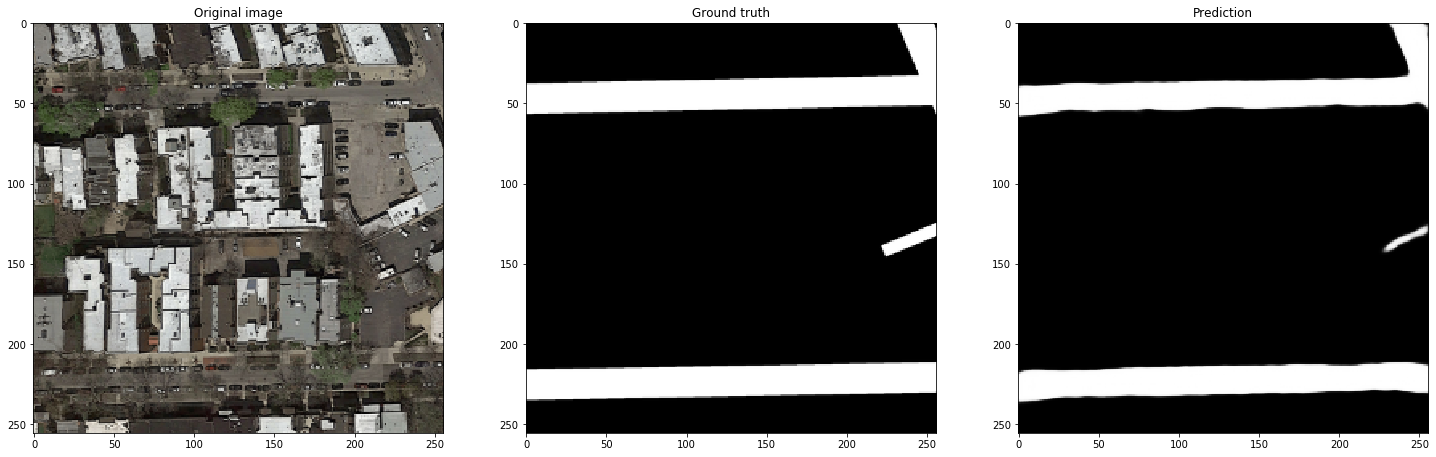

In [ ]:
n=32

plt.figure(figsize=(25,10))
plt.subplot(131)
plt.title('Original image')
plt.imshow(imgs_ext[n], cmap='Greys_r')
plt.subplot(132)
plt.title('Ground truth')
plt.imshow(gts_ext[n].reshape((img_resized_size, img_resized_size)), cmap='Greys_r')
plt.subplot(133)
plt.title('Prediction')
plt.imshow(train_seg[n].reshape((img_resized_size, img_resized_size)), cmap='Greys_r')


# Test set evaluation

In [ ]:
#Load the images and there ground truth 
image_dir = "/content/drive/My Drive/project 2/Stalletite_images_segmentation/Datasets/test_set_images/"

#files to load
files = np.array(os.listdir(image_dir))
files=np.vectorize(lambda x: x+'/'+x+'.png')(files)
n = min(1000, len(files)) 

ordered_files =[]

for i in range(n):
  ordered_files.append('test_'+str(i+1)+'/test_'+str(i+1)+'.png')

print("Loading " + str(n) + " images")
test_imgs = np.array([load_image(image_dir + ordered_files[i]) for i in range(n)])

Loading 50 images


In [ ]:
print('Test images shape', test_imgs.shape)

Test images shape (50, 608, 608, 3)


In [ ]:
test_imgs = np.array([skimage.transform.resize(image, (img_resized_size, img_resized_size, 3)) for image in test_imgs])

test_seg = model.predict(np.array(test_imgs))

if img_size == 400 : # resize the mask back to 608 for submission
    test_seg = np.array([skimage.transform.resize(image, (608, 608)) for image in test_seg])

test_seg=np.array(test_seg)
#test_seg=np.vectorize(lambda x : 1 if x>0.5 else 0)(test_seg)

In [ ]:
test_seg.shape

(50, 608, 608, 1)

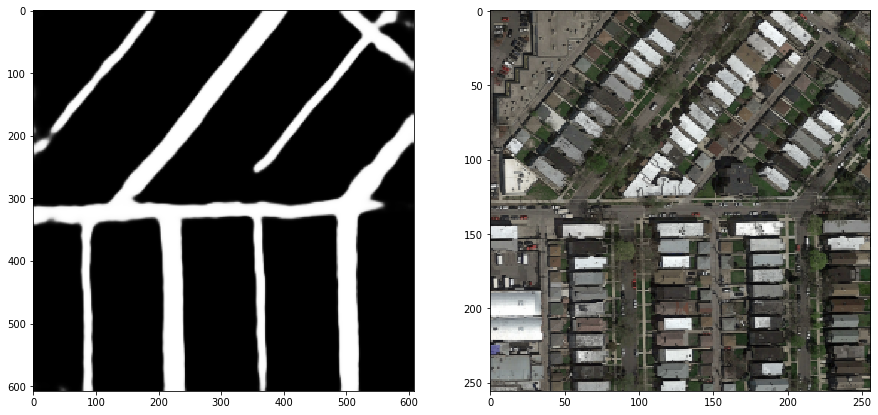

In [ ]:
n=46


plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(test_seg[n].reshape((608,608)), cmap='Greys_r')
plt.subplot(122)
plt.imshow(test_imgs[n], cmap='Greys_r')
plt.savefig("/content/drive/My Drive/project 2/Stalletite_images_segmentation/Datasets/test_example", format="png")

In [ ]:
import cv2

def to_binary(img):
  thresh = skimage.filters.threshold_otsu(img)
  binary = img > thresh
  return binary

def to_binary_set(imgs_set):
  bin_imgs = imgs_set.copy()
  for i in range(len(imgs_set)):
    bin_imgs[i] = to_binary(imgs_set[i])
  return bin_imgs

def remove_islands_img(img, min_size=300):
  #Get binary image from grayscale
  img = to_binary(img)
  #find all your connected components (white blobs in your image)
  nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(binary.astype(np.uint8), connectivity=8)
  #connectedComponentswithStats yields every seperated component with information on each of them, such as size
  #the following part is just taking out the background which is also considered a component, but most of the time we don't want that.
  sizes = stats[1:, -1]; nb_components = nb_components - 1

  # minimum size of particles we want to keep (number of pixels)
  #here, it's a fixed value, but you can set it as you want, eg the mean of the sizes or whatever
  #min_size = 100 

  #your answer image
  img2 = np.zeros((output.shape))
  #for every component in the image, you keep it only if it's above min_size
  for i in range(0, nb_components):
      if sizes[i] >= min_size:
          img2[output == i + 1] = 255
  #return new binary image
  return img2

def remove_islands(imgs_set):
  new_imgs_set = np.zeros((50,608,608))
  for i in range(len(imgs_set)):
    new_imgs_set[i] = remove_islands_img(imgs_set[i])
  return new_imgs_set

In [ ]:
new_test_seg = remove_islands(test_seg)
new_test_seg = new_test_seg.reshape((50,608,608,1))


In [ ]:
def smooth_img(imgs_set, ksize=16): #ksize must be an even number
  tmp_imgs_set = imgs_set.copy()
  for i in range(len(imgs_set)):
    img = imgs_set[i]
    for j in range(1,ksize,2):
      img = cv2.medianBlur(src = img.astype('uint8'),ksize = j)
    tmp_imgs_set[i] = img.reshape((608,608,1)) 
  return tmp_imgs_set

In [ ]:
test_seg_bin = to_binary_set(test_seg)
test_seg_smooth = smooth_img(test_seg_bin)
test_seg_smooth.shape

(50, 608, 608, 1)

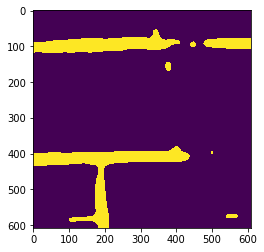

In [ ]:
plt.imshow(test_seg_smooth[24].reshape((608,608)))

# Submission

In [ ]:
import os
import numpy as np
import matplotlib.image as mpimg
import re

foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

# assign a label to a patch
def patch_to_label(patch):
    df = np.mean(patch)
    if df > foreground_threshold:
        return 1
    else:
        return 0


def mask_to_submission_strings(img,i):
    """Reads a single image and outputs the strings that should go into the submission file"""
    img_number = i+1
    im = img[i]
    patch_size = 16
    for j in range(0, im.shape[1], patch_size):
        for i in range(0, im.shape[0], patch_size):
            patch = im[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch)
            yield("{:03d}_{}_{},{}".format(img_number, j, i, label))


def masks_to_submission(submission_filename, imgs):
    """Converts images into a submission file"""
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for i in range(len(imgs)):
            f.writelines('{}\n'.format(s) for s in mask_to_submission_strings(imgs,i))

In [ ]:
masks_to_submission('/content/drive/My Drive/project 2/Stalletite_images_segmentation/Datasets/submission_test_3_smooth.csv', test_seg_smooth)